# Diffusion for Audio

In this notebook we're going to take a brief look at generating audio with diffusion models. 

## What you will learn:
- How audio is represented in a computer
- Methods to convert between audio data and spectrograms
- How to prepare a dataloder with a custom collate function to convert audio slices into spectrogram
- Fine-tuning an existing audio diffusion model on a specific genre of music
- Uploading your custom pipeline to the Hugging Face hub

Let's get started!

## Setup and Imports

In [ ]:
# !pip install -q datasets diffusers torchaudio

In [ ]:
import torch, random
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from IPython.display import Audio
from diffusers import DiffusionPipeline
from torchaudio import transforms as AT
from torchvision import transforms as IT

## Sampling from a Pre-Trained Audio Pipeline

Let's begin by following the [Audio Diffusion docs](https://huggingface.co/docs/diffusers/api/pipelines/audio_diffusion) to load a pre-existing audio diffusion model pipeline:

In [ ]:
# Load a pre-trained audio diffusion pipeline
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DiffusionPipeline.from_pretrained("teticio/audio-diffusion-instrumental-hiphop-256").to(device)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

As with the pipelines we've used in previous units, we can create samples by calling the pipeline like so:

  0%|          | 0/1000 [00:00<?, ?it/s]

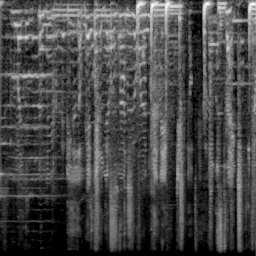

In [ ]:
# Sample from the pipeline and display the outputs:
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))

You'll notice there are multiple things returned by the pipeline. What's going on here? Let's take a closer look at both outputs.

The first is an array of data, representing the generated audio:

In [ ]:
# The audio array:
output.audios[0].shape

(1, 130560)

The second looks like a greyscale image:

In [ ]:
# The output image (spectrogram):
output.images[0].size

(256, 256)

This gives us a hint at how this pipeline works. The audio is not directly generated with diffusion - instead, the pipeline has the same kind of 2D UNet as the unconditional image generation pipelines we saw in Unit 1 that is used to generate the spectrogram, which is then post-processed into the final audio. 

The pipe has an extra component that handles these conversions, which we can access via `pipe.mel`:

In [ ]:
pipe.mel

Mel {
  "_class_name": "Mel",
  "_diffusers_version": "0.12.0.dev0",
  "hop_length": 512,
  "n_fft": 2048,
  "n_iter": 32,
  "sample_rate": 22050,
  "top_db": 80,
  "x_res": 256,
  "y_res": 256
}

## From Audio to Image and Back Again



Describe transforms

![torchaudio docs diagram](https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png)
_Some audio transforms from the [torchaudio docs](https://pytorch.org/audio/stable/transforms.html)_

We can convert the spectrogram image to audio using the pipeline's `mel` functionality:

In [ ]:
a = pipe.mel.image_to_audio(output.images[0])
a.shape

(130560,)

And we can convert an array of audio data into a spectrogram images:

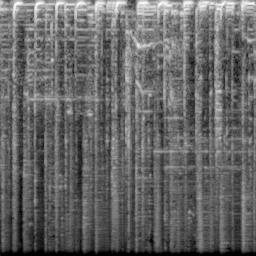

In [ ]:
pipe.mel.load_audio(raw_audio=a)
im = pipe.mel.audio_slice_to_image(0)
im

The audio is represented as a long array of numbers. To play this we need one more key piece of information: the sample rate. How many samples (individual values) do we use to represent a single second of audio? 

We can see the sample rate used during training of this pipeline with:

In [ ]:
sample_rate_pipeline = pipe.mel.get_sample_rate()
sample_rate_pipeline

22050

## Fine-Tuning the pipeline

The dataset:

In [ ]:
from datasets import load_dataset
dataset = load_dataset('lewtun/music_genres', split='train')
dataset

Using custom data configuration lewtun--music_genres-2cfa9201f94788d8
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/lewtun___parquet/lewtun--music_genres-2cfa9201f94788d8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['audio', 'song_id', 'genre_id', 'genre'],
    num_rows: 19909
})

The dataset has the audio as arrays:

In [ ]:
audio_array = dataset[0]['audio']['array']
sample_rate_dataset = dataset[0]['audio']['sampling_rate']
print('Audio array shape:', audio_array.shape)
print('Sample rate:', sample_rate_dataset)
display(Audio(audio_array, rate=sample_rate_dataset))

Audio array shape: (1323119,)
Sample rate: 44100


We can use the Mel thing from earlier to convert the audio to images, but we want a consistent size which might not match the length of our clips

Talk about slicing:

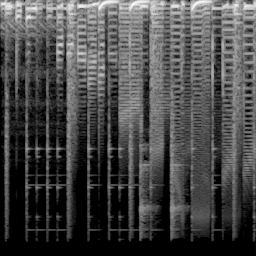

In [ ]:
a = dataset[0]['audio']['array']
pipe.mel.load_audio(raw_audio=a)
pipe.mel.audio_slice_to_image(0)

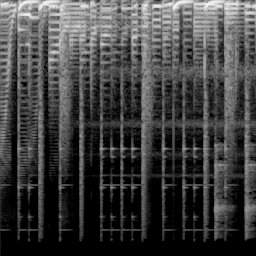

In [ ]:
pipe.mel.audio_slice_to_image(1) # The next 'slice' (about 5s worth of audio)

In [ ]:
# TODO back to audio and listen to sound (it is sped up or slow)
# Talk about resampling

In [ ]:
sample_rate_dataset = dataset[0]['audio']['sampling_rate']

We also need to think about sampling rate:

In [ ]:
resampler = AT.Resample(sample_rate_dataset, sample_rate_pipeline, dtype=torch.float32)
to_t = IT.ToTensor()

def to_image(audio_array):
  audio_tensor = torch.tensor(audio_array).to(torch.float32)
  audio_tensor = resampler(audio_tensor)
  pipe.mel.load_audio(raw_audio=np.array(audio_tensor))
  num_slices = pipe.mel.get_number_of_slices()
  slice_idx = random.randint(0, num_slices-1) # Pic a random slice each time (excluding the last short slice)
  im = pipe.mel.audio_slice_to_image(slice_idx) 
  return im

Dataloaders

In [ ]:
# Print the genres and available samples for each:
for g in list(set(dataset['genre'])):
  print(g, sum(x==g for x in dataset['genre']))

Jazz 306
Electronic 3071
International 814
Country 142
Punk 2582
Old-Time / Historic 408
Blues 58
Chiptune / Glitch 1181
Ambient Electronic 796
Easy Listening 13
Classical 495
Folk 1214
Hip-Hop 1757
Spoken 94
Rock 3095
Experimental 1800
Soul-RnB 94
Pop 945
Instrumental 1044


In [ ]:
def collate_fn(examples):
  audio_ims = [to_t(to_image(x['audio']['array']))*2-1 for x in examples]
  return torch.stack(audio_ims)

# Create a dataset with only the 'Chiptune / Glitch' genre of songs
batch_size=12 # 4 on colab, 12 on A100
chosen_genre = 'Chiptune / Glitch'
indexes = [i for i, g in enumerate(dataset['genre']) if g == chosen_genre]
filtered_dataset = dataset.select(indexes)
dl = torch.utils.data.DataLoader(filtered_dataset.shuffle(), batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
batch = next(iter(dl))
print(batch.shape)

torch.Size([12, 1, 256, 256])


In [ ]:
len(dl)

99

## Training Loop

In [ ]:
epochs = 3
lr = 3e-4

pipe.unet.train()
pipe.scheduler.set_timesteps(1000)
optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

for epoch in range(epochs):
    for step, batch in tqdm(enumerate(dl), total=len(dl)):
        
        # Prepare the input images
        clean_images = batch.to(device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, pipe.scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        noisy_images = pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

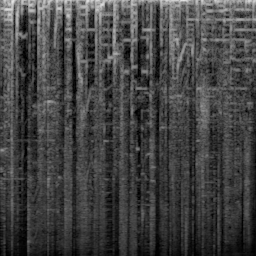

In [ ]:
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

  0%|          | 0/1000 [00:00<?, ?it/s]

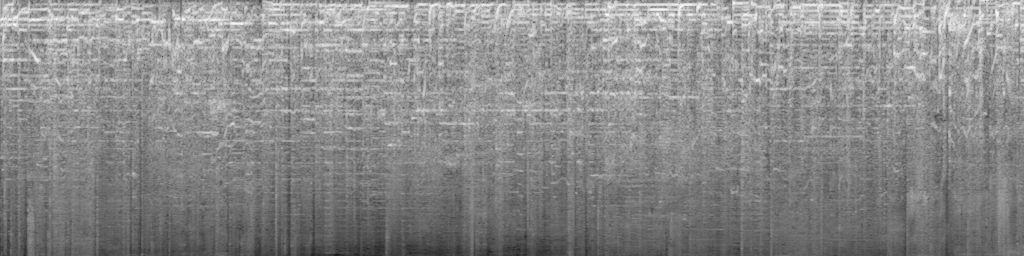

In [ ]:
# Make a longer sample by passing in a starting noise tensor with a different shape
noise = torch.randn(1, 1, pipe.unet.sample_size[0],pipe.unet.sample_size[1]*4).to(device)
output = pipe(noise=noise)
display(output.images[0])
display(Audio(output.audios[0], rate=22050))

Some things to consider
- We're working with 256px square spectrogram images which limmits our batch size. Can you recover audio of sufficient quality from a 128x128 spectrogram?
- In place of random image augmentation we're picking different slices of the audio clip each time, but could this be improved with some different kinds of augmentation when training for many epochs?
- How else might we use this to generate longer clips? Perhaps you could generate a 5s starting clip and then use inpainting-inspired ideas to continue to generate additional segments of audio that follow on from the initial clip...
- What is the equivalent of image-to-image in this spectrogram diffusion context?

## Push to Hub

Once you're happy with your model, you can save it and push it to the hub for others to enjoy:

In [ ]:
from huggingface_hub import get_full_repo_name, HfApi, create_repo, ModelCard

In [ ]:
# Pick a name for the model
model_name = "chiptunes_test"
hub_model_id = get_full_repo_name(model_name)

In [ ]:
# Save the pipeline locally
pipe.save_pretrained(model_name)

In [ ]:
# Inspect the folder contents
!ls {model_name}

mel  model_index.json  scheduler  unet


In [ ]:
# Create a repository
create_repo(hub_model_id)

'https://huggingface.co/johnowhitaker/chiptunes_test'

In [ ]:
# Upload the files
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/mel", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/johnowhitaker/chiptunes_test/blob/main/model_index.json'

In [ ]:
# Push a model card

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-audio-generation
- diffusion-models-class
---

# Model Card for Unit 4 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional audio generation of music in the genre {chosen_genre}

## Usage

```python
from IPython.display import Audio
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("{hub_model_id}")
output = pipe()
display(output.images[0])
display(Audio(output.audios[0], rate=pipe.mel.get_sample_rate()))
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/johnowhitaker/chiptunes_test/blob/main/README.md'

## Conclusion

This notebook has hopefully given you a small taste of the potential of audio generation. Check out some of the references linked from the introduction to this unit to see some fancier methods and the astounding samples they can create!